### Data Augmentation

In this notebook data augmentation is performed for improving the performances of the ConvLSTM model. 

In [1]:
%cd ..
%cd ..
# move to the root directory of the git

/workspace/FLOOD_group2/models
/workspace/FLOOD_group2


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import importlib
import torch
import joblib
import copy
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn as nn

# Enable interactive widgets in Jupyter Notebook
%matplotlib widget

from torchsummary import summary
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch.optim.lr_scheduler import StepLR

from models.ConvLSTM_model.ConvLSTM_pytorch.convlstm import ConvLSTM
from models.ConvLSTM_model.ConvLSTM_pytorch.multistep_convlstm import MultiStepConvLSTM
from models.ConvLSTM_model.train_eval import train_epoch_conv_lstm, evaluation_conv_lstm
from pre_processing.encode_decode_csv import decode_from_csv
from pre_processing.normalization import * 
from pre_processing.augmentation import *
from post_processing.cool_animation import plot_animation
from post_processing.plots import *

In [3]:
# model save path
save_path = 'models/ConvLSTM_model/model_paths/multi_step_16hid_8lay_5ker_halfbatch.pth' 
#'models/ConvLSTM_model/model_paths/multiconv_lstm_32hid_2lay_3ker_augmentation.pth'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


The following string is used to tell the functions which directory to look into to obtain the data.

In [5]:
train_val = 'train_val'

In [6]:
# training and validation dataset
train_dataset = decode_from_csv(train_val)

Restored inputs Shape: torch.Size([80, 1, 4, 64, 64])
Restored targets Shape: torch.Size([80, 48, 2, 64, 64])


In [7]:
# apply augmentation
transformed_dataset = augmentation(train_dataset)

The samples in the dataset before augmentation were 80
The samples in the dataset after augmentation are 560


In [8]:
# Split dataset into train and validation
random_gen = torch.Generator().manual_seed(42) # find a random seed and fix it to always have the same split

train_percnt = 0.8
train_size = int(train_percnt * len(transformed_dataset))
val_size = len(transformed_dataset) - train_size
train_set, val_set = random_split(transformed_dataset, [train_size, val_size], random_gen)

This notebook was last used to train this model on our third runpod. The error below occurs because of a certain version of matplotlib which is not used in the DSAIE environment. Since this was trained the night before the presentation, it was not solved in time. The error is related to placing an x at the boundary location and is not critical to training the model.

TypeError: 'clipbox' must be an instance of matplotlib.transforms.BboxBase or None, not a matplotlib.transforms.CompositeGenericTransform

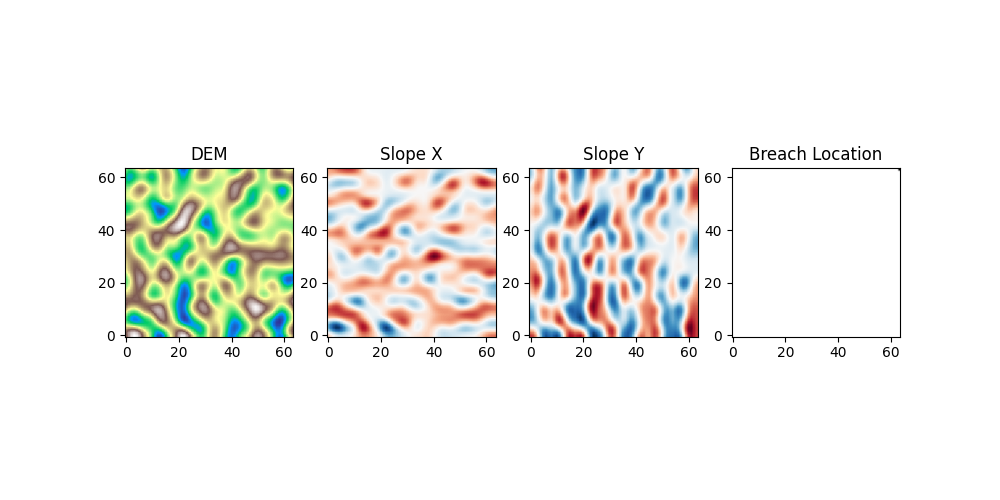

In [9]:
# From FAT application
fig, axs = plt.subplots(1, 4, figsize=(10, 5))

# specify which entry of the dataset to plot
numb = 20
inputs = train_set[numb][0][0]

axs[0].imshow(inputs[0].cpu(), cmap='terrain', origin='lower')
axs[0].set_title('DEM')

axs[1].imshow(inputs[1].cpu(), cmap='RdBu', origin='lower')
axs[1].set_title('Slope X')

axs[2].imshow(inputs[2].cpu(), cmap='RdBu', origin='lower')
axs[2].set_title('Slope Y')

non_zero_indices = torch.nonzero(inputs[3].cpu())
non_zero_row, non_zero_col = non_zero_indices[0][0].item(), non_zero_indices[0][1].item()
axs[3].imshow(inputs[3].cpu(), cmap='binary', origin='lower')
axs[3].set_title('Breach Location')
axs[3].scatter(non_zero_col, non_zero_row, color='k', marker='x', s=100,
                clip_on = False, clip_box = plt.gca().transData)
plt.show()

In [10]:
# Normalize the inputs and outputs using training dataset
scaler_x, scaler_y = scaler(train_set)

normalized_train_dataset = normalize_dataset(train_set, scaler_x, scaler_y, train_val)
normalized_val_dataset = normalize_dataset(val_set, scaler_x, scaler_y, train_val)

In [11]:
## save scalers for use in seperate notebooks on testing, should not change unless seed is changed or augmentation increased (randomsplit changes)
joblib.dump(scaler_x, 'models/ConvLSTM_model/scalers/scaler_x.joblib')
joblib.dump(scaler_y, 'models/ConvLSTM_model/scalers/scaler_y.joblib');

In [12]:
# Model
model = MultiStepConvLSTM(input_dim = normalized_train_dataset[0][0].shape[1],
                          output_dim = normalized_train_dataset[0][1].shape[1], 
                          hidden_dim = 16, kernel_size = (5, 5), num_layers = 8,
                          batch_first=True, bias=True, return_all_layers = False).to(device)

# model = ConvLSTM(input_dim = normalized_train_dataset[0][0].shape[1], output_dim = normalized_train_dataset[0][1].shape[1], hidden_dim = 32, kernel_size = (3, 3),
#                  num_layers = 48, batch_first=True, bias=True, return_all_layers = True).to(device)

# return all layers has to be true to obtain all the outputs I think
# num_layers refers to the number of cells and thus outputs
# Number of outputs = 4 gates * hidden_dim

In [13]:
model

MultiStepConvLSTM(
  (conv2): Conv2d(16, 2, kernel_size=(1, 1), stride=(1, 1))
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(20, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1-7): 7 x ConvLSTMCell(
      (conv): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
)

*Note:* **bold text is different from other conv lstm model**

**Given a specific hidden dimension <code>hidden_dim</code> and input dimension <code>input_dim</code>, the first layer receives the <code>hidden_dim</code> as hidden dimension of previous time step and <code>input_dim</code> as input dimension of the current time step and outputs <code>hidden_dim</code> to the next time step and next layer at current time step. Therefore, the next layer receives <code>hidden_dim</code> as both hidden dimension of previous time step and input dimension of current time step and outputs <code>hidden_dim</code> for both next time step and next layer and so on.**

**With this model, each layer is shared with all the time steps. This means that any number of layers can be included into the model architecture (can therefore be generalized to a forecast of any sequence length). To limit shattered gradients, this should be reduced, however, a balance needs to be struck as it also introduces hiearichal bias, which allows for a smaller model to provide decent results**

**To reduce the effect of shattered gradients (https://arxiv.org/pdf/1609.08144.pdf%20(7.pdf) recommends using residual connections, which is a point wise sum between the current layer output and the previous layer output. We took in one step further and connect the current layer output with all the previous layer inputs (excluding the inputs as the number of channels is different). This theoretically makes it easier to propogate the gradients as it is easier to isolate individual layers during the backpropogation of the loss.**

The model has only one convolutional layer located before the gates. This layer outputs a <code>4*hidden_dim</code> to each gate because there are 4 gates (input, forget, tanh activation and output The cell than outputs <code>hidden_dim</code> as there is a point wise sum between the cell state and the output gate. This is given to the next layer as input or the next time step as hidden state.)ded.

The convolutional layer implements the spatial bias, while the LSTM cells implement sequential This model should therefore require the least amount of parameters out of the four models in this repository.

After the last point wise sum, the channels will be equal to hidden_dim. To reduce to the two targets two 1x1 kernels are shared with all time steps. This would equal 4 weights The alternative was an MLP (or fully connected layer), which would result in a number of parameters equal to hidden_dim x pixels x pixels x output_dim + 2(bias), that is more than 100,000 parameters in total. It is clear that such model would increase the computational cost significantly. Especially if our models is within this order of magnitude. A 1x1 kernel is a valid option to use as discharge is highly correlated to water depth.ficantly.

After the 1x1 kernel we could activate the output channels. One possible option was to use <code>ReLU</code> because we expect only positive values of the targets (water depth and discharge) so we want predictions to be positive as well. We eventually did not implement this because in the earlier stages of the training the model weights were not efficiently updated to learn the flood evolution. Without ReLU activation the model can produce negative results which increase the loss and enhance the model learning. On the other hand, this means that the model can predicet negative values which are always not expectehe learning.  

In [14]:
num_parameters = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_parameters}")
model_size_MB = num_parameters * 4 / (1024 ** 2)  # Assuming float32 precision
print(f"Model size: {model_size_MB:.2f} MB")

Number of parameters: 390946
Model size: 1.49 MB


In [16]:
# Set training parameters
learning_rate = 0.001
batch_size = len(val_set)//2 # run out of memory when performing full batch 
num_epochs = 2_000 # Run for more epochs to avoid early stopping during stagnation of validation loss

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
# Create scheduler for decreasing the learning rate every 500 epochs with a factor 0.8
scheduler = StepLR(optimizer, step_size = 200, gamma = 0.8)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(normalized_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(normalized_val_dataset, batch_size=batch_size, shuffle=False)

This model took 2 minutes per epoch. We were therefore printing every epoch to monitor the training early on. The reason we went for such a large batch size is because this GPU allowed it, but also because we had performed a large amount of augmentation, and wanted the model to have a large variety per batch when training. We believed this would give the best generalization with respect to dataset 2.

A scheduler was used as in previous iterations of the model it helped with convergence, in this case, the step size may have been too large due to the runtime.

In [18]:
train_losses = []
val_losses = []

loss_f = 'MSE'

for epoch in range(1, num_epochs+1):
    scheduler.step() # update the learning rate
    # Model training
    train_loss = train_epoch_conv_lstm(model, train_loader, optimizer, device, loss_f = loss_f)

    # Model validation
    val_loss = evaluation_conv_lstm(model, val_loader, device, loss_f = loss_f)

    if epoch == 1:
        best_loss = val_loss
    
    if val_loss<=best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch
        count = 0

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    count += 1
    
    if epoch%1 == 0:
        print(f"Epoch: {epoch} " +
              f"\t Training loss: {train_loss: .2e} " + 
              f"\t Validation loss: {val_loss: .2e} " +
              f"\t Best validation loss: {best_loss: .2e}")
        print(f'Current learning rate: {scheduler.get_last_lr()[0]}')
    # stop_count = 100
    # if count > stop_count:
    #     print(f"Loss Stagnated for {stop_count} epochs, early stopping initiated")
        # break

Epoch: 1 	 Training loss:  1.39e-01 	 Validation loss:  6.91e-03 	 Best validation loss:  6.91e-03
Current learning rate: 0.001
Epoch: 2 	 Training loss:  7.22e-03 	 Validation loss:  6.93e-03 	 Best validation loss:  6.91e-03
Current learning rate: 0.001
Epoch: 3 	 Training loss:  5.18e-03 	 Validation loss:  4.89e-03 	 Best validation loss:  4.89e-03
Current learning rate: 0.001
Epoch: 4 	 Training loss:  4.26e-03 	 Validation loss:  4.30e-03 	 Best validation loss:  4.30e-03
Current learning rate: 0.001
Epoch: 5 	 Training loss:  3.92e-03 	 Validation loss:  3.93e-03 	 Best validation loss:  3.93e-03
Current learning rate: 0.001
Epoch: 6 	 Training loss:  3.71e-03 	 Validation loss:  3.72e-03 	 Best validation loss:  3.72e-03
Current learning rate: 0.001
Epoch: 7 	 Training loss:  3.57e-03 	 Validation loss:  3.59e-03 	 Best validation loss:  3.59e-03
Current learning rate: 0.001
Epoch: 8 	 Training loss:  3.46e-03 	 Validation loss:  3.50e-03 	 Best validation loss:  3.50e-03
Curre

KeyboardInterrupt: 

After 17 hours, we were forced to keyboard interupt even though the model did seem to continue improving. This demonstrates the difficulties in training a convolution LSTM model. It is highly dependent on the choice of hyperparameters, sequence length, training size and how training is performed. A large batch size and predicting all outputs per batch probably is not the most efficient way to train this model. Training difficulties may have also been caused by attempting to predict both dicharge and water depth.

In [19]:
model = copy.deepcopy(best_model)
torch.save(model.state_dict(), save_path)

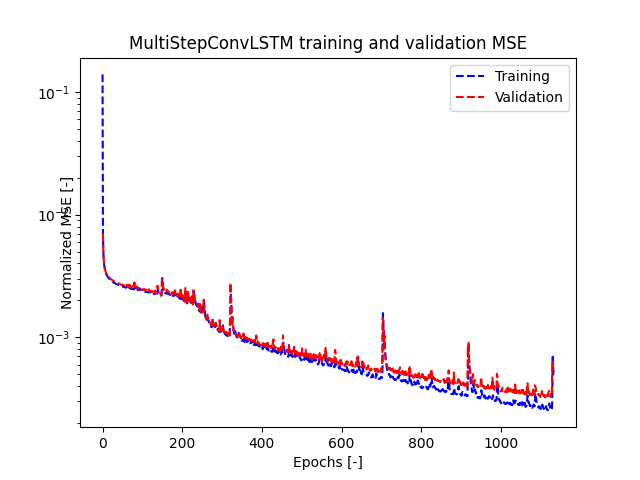

In [20]:
plot_losses(train_losses, val_losses, model, loss_f = loss_f)

Unfortunately, plot animation cannot be used because of the type error issued by plotting the boundary condtion (same as at the start of the notebook)

In [ ]:
plot_animation(30, normalized_val_dataset, model, train_val,
               scaler_x, scaler_y, device = device, save = True, loss_f = loss_f)

Since the validation set includes 112 samples, plot sorted was not used as it would induce a large amount of clutter

In [ ]:
plot_sorted(normalized_val_dataset, model, train_val, scaler_x, scaler_y, device, loss_f = loss_f)